# SSF-MCMC vs QAOA学習データ

すでに行なった実験を設定を修正して再実験。

## import

In [1]:
import numpy as np
import scipy
import networkx as nx
import matplotlib.pyplot as plt
import time
import IProgress
from tqdm.notebook import tqdm
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qulacs import QuantumState
from skqulacs.circuit import LearningCircuit
import qulacsvis as qvis

import made
from made import MADE
import mcmc_function as mcmc
import ising_model as ising
from ising_model import Ising_model
import QAOA_function as qaoa
from QAOA_function import QAOA_ansatz

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['mathtext.fontset'] = 'cm'

seed = 729
rng = np.random.default_rng(seed)

## 1. インスタンス準備

In [2]:
n_spin = 10
instance = Ising_model(n_spin, seed, type='SK')

## 2. 教師データ準備

### 設定

In [3]:
# MADE
n_step = n_spin # 間引きの間隔
n_samples = 2 ** n_spin
n_data_list = [n_spin, n_spin**2, 2**n_spin]

# spectral gap
beta_list = np.logspace(-2, 2, 41)

### SSF教師データサンプリング

In [4]:
# sampling
mcmc_data = np.zeros([beta_list.shape[0], n_step*n_samples, n_spin])
spin_data = np.zeros([beta_list.shape[0], n_samples, n_spin])

j = 0
for beta in tqdm(beta_list):
	init_spin = mcmc.number_to_spin(rng.integers(0, 2**n_spin), n_spin)
	for i in range(n_step*n_samples):
		# update
		if i == 0:
			mcmc_data[j,0] = mcmc.ssf_update(init_spin, instance, beta, seed)[0]
		else:
			mcmc_data[j,i] = mcmc.ssf_update(mcmc_data[j,i-1], instance, beta, seed)[0]

		# data
		if i % n_step == n_step-1:
			spin_data[j,(i//n_step)] = mcmc_data[j,i]
	
	ssf_data_id = np.array([mcmc.spin_to_number(spin_data[j,i]) for i in range(spin_data.shape[1])])
	ssf_data_nd = np.array([qaoa.number_to_binary(ssf_data_id[i], n_spin) for i in range(ssf_data_id.shape[0])], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！

	if j == 0:
		ssf_data = ssf_data_nd[np.newaxis]
	else:
		ssf_data = np.concatenate([ssf_data, ssf_data_nd[np.newaxis]])
  
	j += 1

  0%|          | 0/41 [00:00<?, ?it/s]

### 確認

In [5]:
print(ssf_data.shape)
print(ssf_data.dtype)

(41, 1024, 10)
float32


### QAOA教師データサンプリング

In [6]:
# setting
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
n_layers = 5
qaoa_ansatz = QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)

def cost(para):
    return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)

def callback(para):
    para_history.append(para)
    cost_history.append(cost(para))

# running QAOA
#init_para = [rng.uniform(0, 2*np.pi) for i in range(2*n_layers)]
init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
para_history = [init_para]
cost_history = [cost(init_para)]

method = "BFGS"
options = {"disp": True, "maxiter": 200, "gtol": 1e-6}
opt = scipy.optimize.minimize(cost, init_para, 
                              method=method,
                              callback=callback,
                              options=options)

opt_para = para_history[-1]

# sampling QAOA outputs
opt_qaoa_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, para_history[-1], n_samples) # optimize parameter
fix_qaoa_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, init_para, n_samples) # fixed angle

opt_qaoa_data_nd = np.array([qaoa.number_to_binary(opt_qaoa_data_idx[i], n_spin) for i in range(len(opt_qaoa_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！
fix_qaoa_data_nd = np.array([qaoa.number_to_binary(fix_qaoa_data_idx[i], n_spin) for i in range(len(fix_qaoa_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！

Optimization terminated successfully.
         Current function value: -6.867292
         Iterations: 29
         Function evaluations: 440
         Gradient evaluations: 40


## 3. MADE学習 & spectral gap計算

### 設定

In [7]:
hidden_size = int(2 * n_spin)
hidden_layers = 2
hidden_list = [hidden_size for i in range(hidden_layers)]

batchsize = 8
lr = 0.005
n_epochs = 30

In [8]:
def calc_mh_gap(energy_vector, proposal_mat, beta):
    n_state = energy_vector.shape[0]
    
    P = np.zeros((n_state, n_state))
    A = mcmc.calc_boltzmann_mh_acceptance(energy, proposal_mat, beta)
    P = proposal_mat * A
    np.fill_diagonal(P, 0)
    
    for i in range(2**n_spin):
        P[i,i] = 1 - np.sum(P[:,i])
        
    return mcmc.spectral_gap(P)

def calc_metropolis_gap(energy_vector, proposal_mat, beta):
    n_state = energy_vector.shape[0]
    
    P = np.zeros((n_state, n_state))
    A = mcmc.calc_boltzmann_metropolis_acceptance(energy, beta)
    P = proposal_mat * A
    np.fill_diagonal(P, 0)
    
    for i in range(2**n_spin):
        P[i,i] = 1 - np.sum(P[:,i])
        
    return mcmc.spectral_gap(P)

# prep
ssf_made_gap_list = np.zeros((len(n_data_list), beta_list.shape[0]))
opt_qaoa_made_gap_list = np.zeros((len(n_data_list), beta_list.shape[0]))
fix_qaoa_made_gap_list = np.zeros((len(n_data_list), beta_list.shape[0]))
uni_gap_list = np.zeros((len(n_data_list), beta_list.shape[0]))
ssf_gap_list = np.zeros((len(n_data_list), beta_list.shape[0]))

energy = np.array([ising.spin_energy(ising.number_to_spin(i, n_spin), instance) for i in range(2**n_spin)])
uni_Q = np.ones((2**n_spin, 2**n_spin)) / (2**n_spin) # uniform

ssf_Q = np.zeros((2**n_spin, 2**n_spin)) # single spin-flip
for i in range(2**n_spin):
	spin = mcmc.number_to_spin(i, n_spin)
	for j in range(n_spin):
		flip_spin = mcmc.single_spin_flip(spin, j)
		index = mcmc.spin_to_number(flip_spin)
		ssf_Q[index, i] += 1
for i in range(2**n_spin):
	ssf_Q[:,i] /= np.sum(ssf_Q[:,i])

# main
for j in tqdm(range(len(n_data_list))):
	n_data = n_data_list[j]
	n_train = int(0.8*n_data)
	n_test = n_data - n_train
 
	# train MADE(QAOA)
	opt_qaoa_data_torch = torch.from_numpy(opt_qaoa_data_nd[0:n_data]).to(dtype=torch.float32)
	opt_qaoa_traindata, opt_qaoa_testdata = torch.utils.data.random_split(dataset=opt_qaoa_data_torch, lengths=[n_train, n_test], generator=torch.Generator().manual_seed(seed))
	fix_qaoa_data_torch = torch.from_numpy(fix_qaoa_data_nd[0:n_data]).to(dtype=torch.float32)
	fix_qaoa_traindata, fix_qaoa_testdata = torch.utils.data.random_split(dataset=fix_qaoa_data_torch, lengths=[n_train, n_test], generator=torch.Generator().manual_seed(seed))
 
	model_opt_qaoa = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
	opt_opt_qaoa = torch.optim.Adam(model_opt_qaoa.parameters(), lr=lr, weight_decay=1e-4)
	scheduler_opt_qaoa = torch.optim.lr_scheduler.StepLR(opt_opt_qaoa, step_size=45, gamma=0.1)

	model_fix_qaoa = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
	opt_fix_qaoa = torch.optim.Adam(model_fix_qaoa.parameters(), lr=lr, weight_decay=1e-4)
	scheduler_fix_qaoa = torch.optim.lr_scheduler.StepLR(opt_fix_qaoa, step_size=45, gamma=0.1)

	opt_qaoa_testset = torch.utils.data.DataLoader(opt_qaoa_testdata, batch_size=batchsize, shuffle=False)
	opt_qaoa_trainset = torch.utils.data.DataLoader(opt_qaoa_traindata, batch_size=batchsize, shuffle=True)
	fix_qaoa_testset = torch.utils.data.DataLoader(fix_qaoa_testdata, batch_size=batchsize, shuffle=False)
	fix_qaoa_trainset = torch.utils.data.DataLoader(fix_qaoa_traindata, batch_size=batchsize, shuffle=True)

	made.run_train(model_opt_qaoa, opt_qaoa_trainset, opt_qaoa_testset, n_epochs, opt_opt_qaoa, scheduler_opt_qaoa)
	made.run_train(model_fix_qaoa, fix_qaoa_trainset, fix_qaoa_testset, n_epochs, opt_fix_qaoa ,scheduler_fix_qaoa)

	opt_qaoa_pred_dist = made.sampling_MADE(model_opt_qaoa)
	fix_qaoa_pred_dist = made.sampling_MADE(model_fix_qaoa)
	
	opt_qaoa_made_Q = np.zeros((2**n_spin, 2**n_spin))
	fix_qaoa_made_Q = np.zeros((2**n_spin, 2**n_spin))
	for i in range(2**n_spin):
		opt_qaoa_made_Q[i] = opt_qaoa_pred_dist[i] # MADE(QAOA + opt)
		fix_qaoa_made_Q[i] = fix_qaoa_pred_dist[i] # MADE(QAOA + fixed angle)

	# calculation for each beta
	for i in tqdm(range(len(beta_list)), leave=True):
		beta = beta_list[i]
	
		# train MADE(SSF)
		ssf_data_torch = torch.from_numpy(ssf_data[i,0:n_data]).to(dtype=torch.float32)
		ssf_traindata, ssf_testdata = torch.utils.data.random_split(dataset=ssf_data_torch, lengths=[n_train, n_test], generator=torch.Generator().manual_seed(seed))

		model_opt_qaoa = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
		opt_opt_qaoa = torch.optim.Adam(model_opt_qaoa.parameters(), lr=lr, weight_decay=1e-4)
		scheduler_opt_qaoa = torch.optim.lr_scheduler.StepLR(opt_opt_qaoa, step_size=45, gamma=0.1)

		opt_qaoa_testset = torch.utils.data.DataLoader(opt_qaoa_testdata, batch_size=batchsize, shuffle=False)
		opt_qaoa_trainset = torch.utils.data.DataLoader(opt_qaoa_traindata, batch_size=batchsize, shuffle=True)

		made.run_train(model_opt_qaoa, opt_qaoa_trainset, opt_qaoa_testset, n_epochs, opt_opt_qaoa, scheduler_opt_qaoa)

		ssf_made_pred_dist = made.sampling_MADE(model_opt_qaoa)
		ssf_made_Q = np.zeros((2**n_spin, 2**n_spin))
		for l in range(2**n_spin):
			ssf_made_Q[l] = ssf_made_pred_dist[l]
	
		# calculate spectral gap
		ssf_made_gap_list[j,i] = calc_mh_gap(energy, ssf_made_Q, beta)
		opt_qaoa_made_gap_list[j,i] = calc_mh_gap(energy, opt_qaoa_made_Q, beta)
		fix_qaoa_made_gap_list[j,i] = calc_mh_gap(energy, fix_qaoa_made_Q, beta)
		uni_gap_list[j,i] = calc_metropolis_gap(energy, uni_Q, beta)
		ssf_gap_list[j,i] = calc_metropolis_gap(energy, ssf_Q, beta)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

/Users/yuichiro_nakano/mydrive/Research/Fujii_Lab/Project/NN_proposal_MCMC_used_QAOA_sample/qaoa-made-mcmc/src/lib/mcmc_function.py:141: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(likelihood)
/Users/yuichiro_nakano/mydrive/Research/Fujii_Lab/Project/NN_proposal_MCMC_used_QAOA_sample/qaoa-made-mcmc/src/lib/mcmc_function.py:156: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(likelihood)


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

### 結果の描画

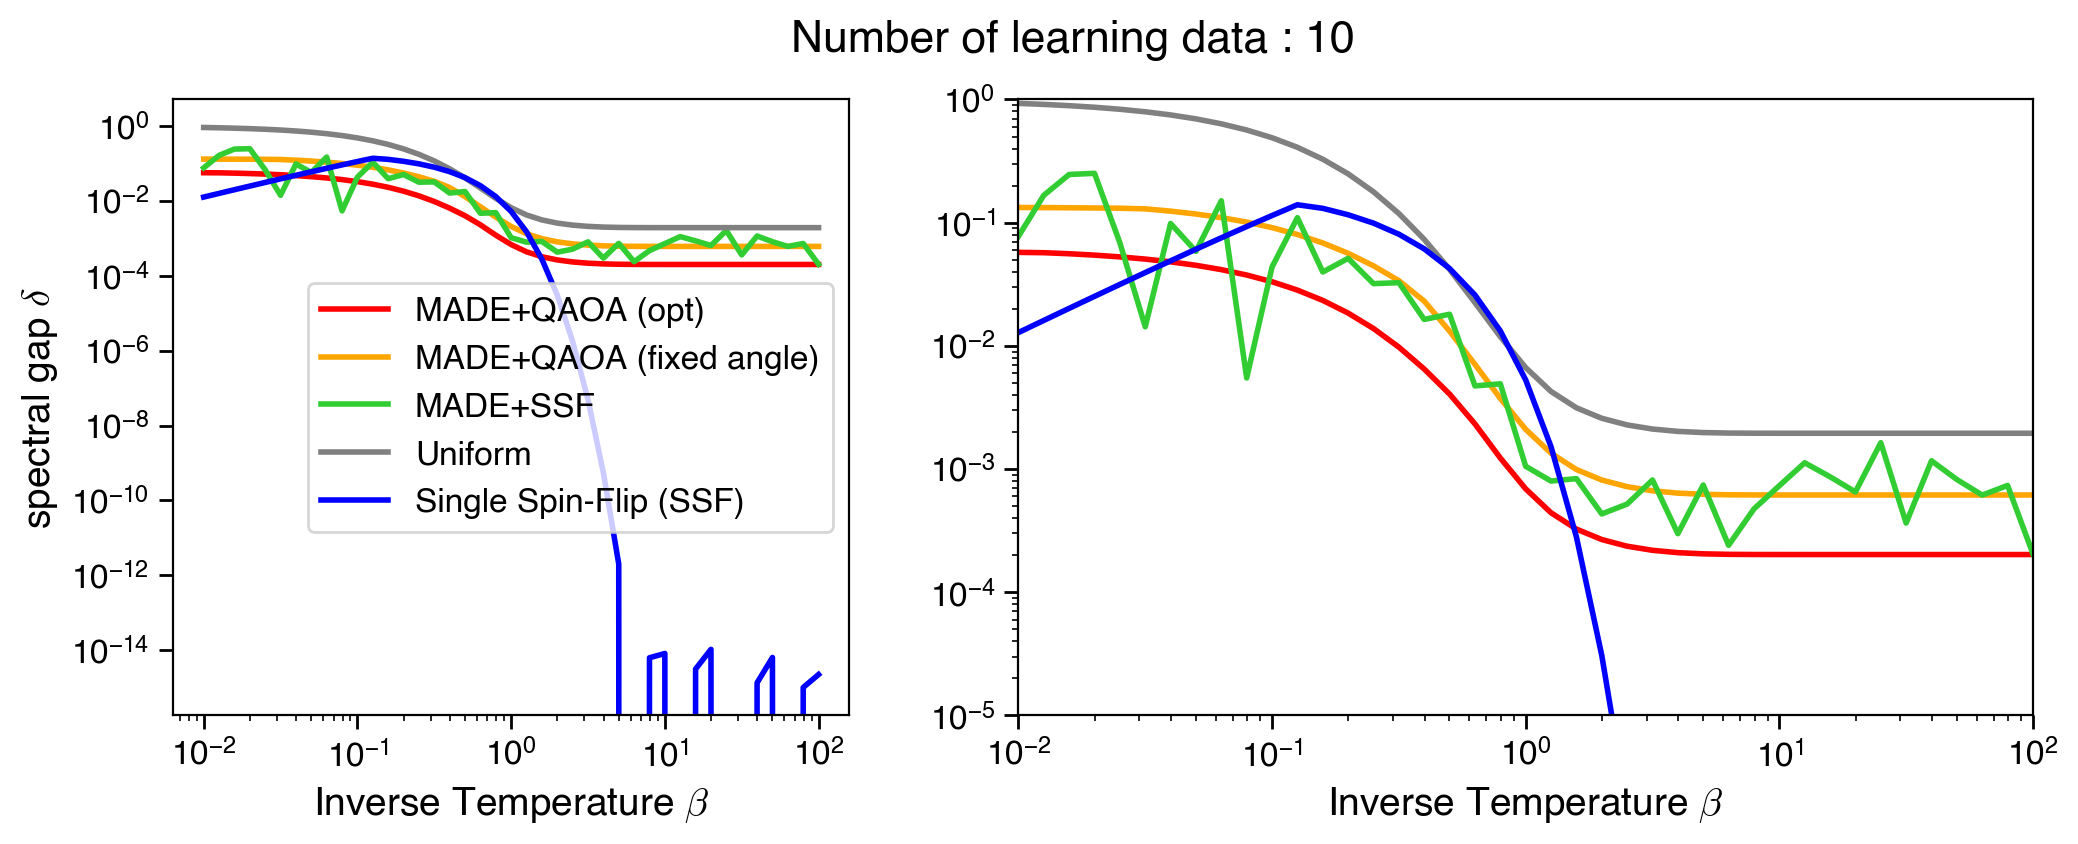

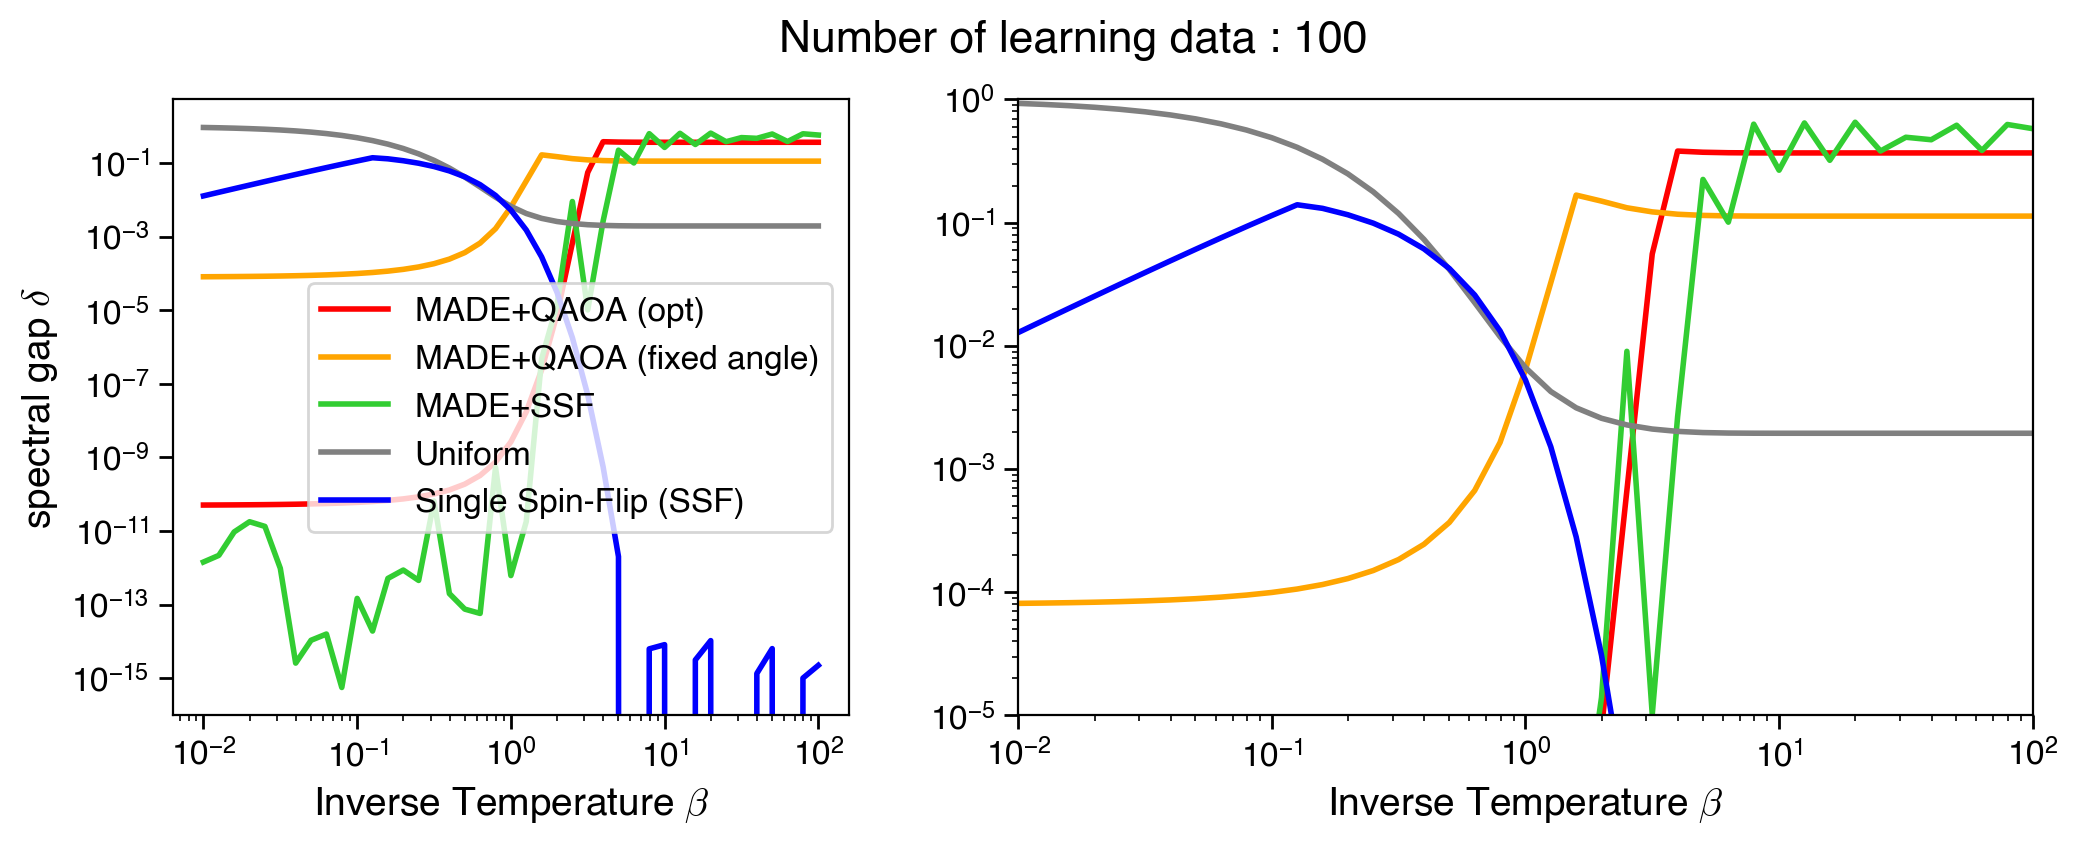

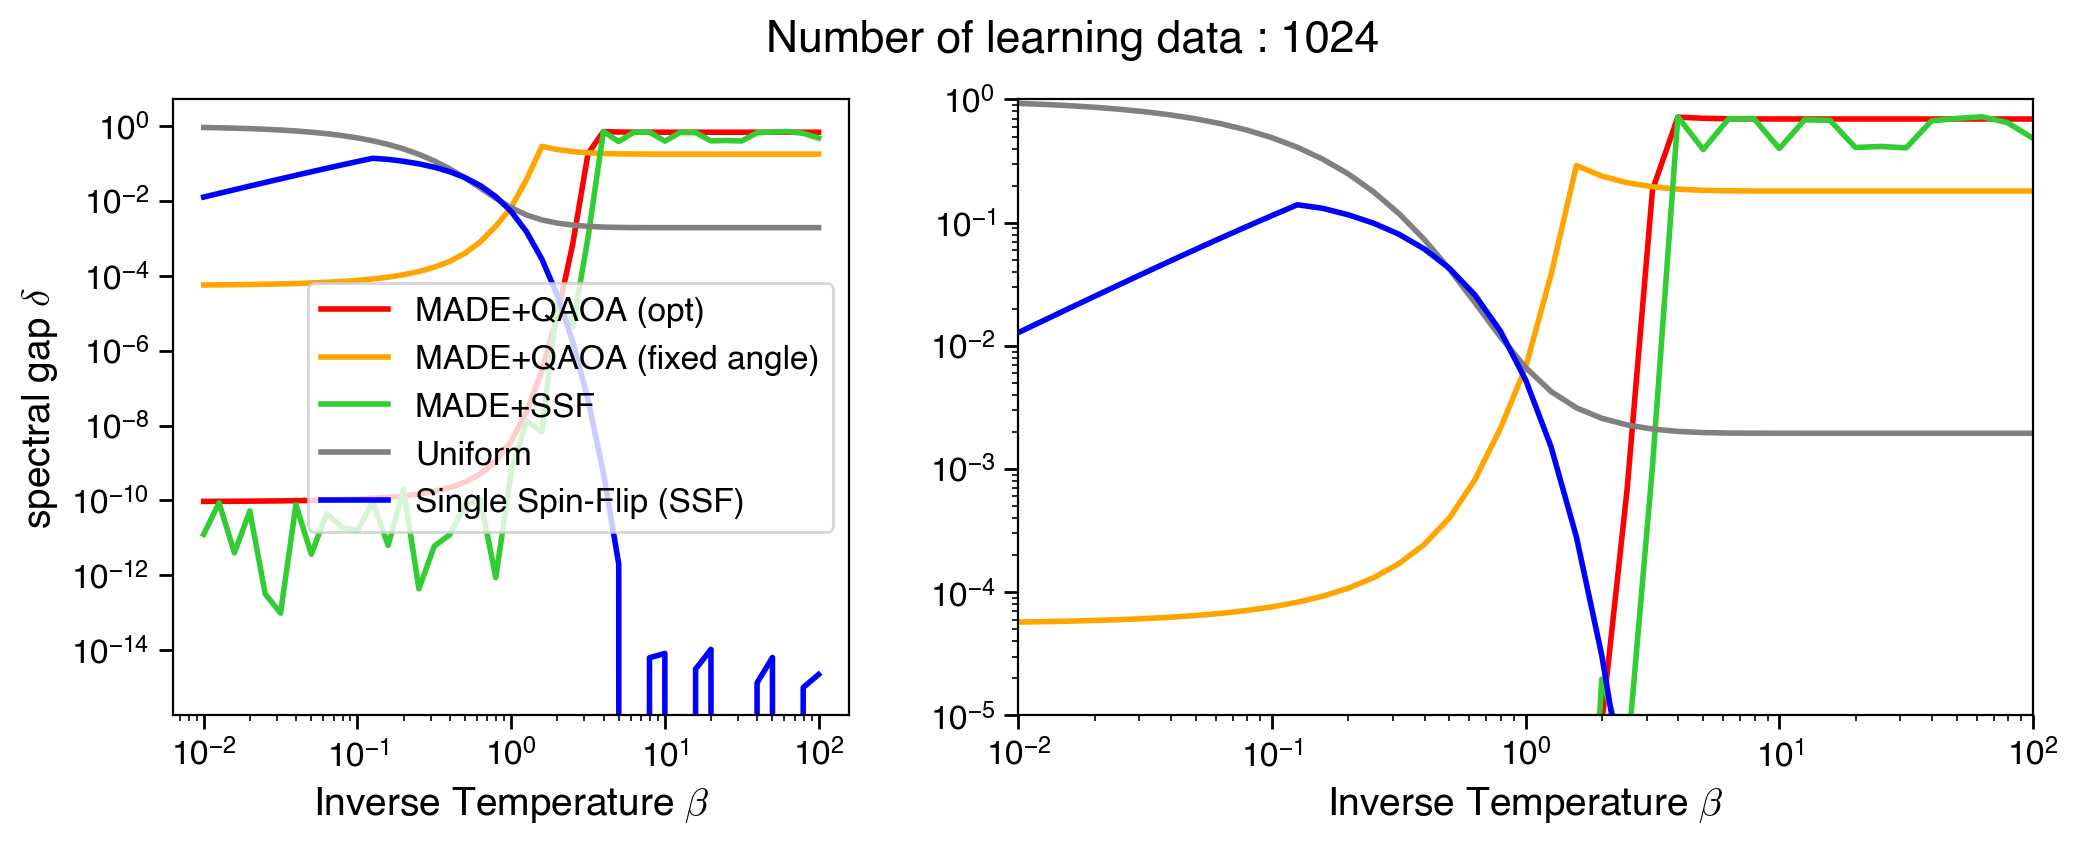

In [12]:
for i in range(len(n_data_list)):
	fig1, ax1 = plt.subplots(1,2, width_ratios=[2,3], figsize=(12,4), dpi=200)

	ax1[0].plot(beta_list, opt_qaoa_made_gap_list[i], linewidth=2, color='red', label='MADE+QAOA (opt)')
	ax1[0].plot(beta_list, fix_qaoa_made_gap_list[i], linewidth=2, color='orange', label='MADE+QAOA (fixed angle)')
	ax1[0].plot(beta_list, ssf_made_gap_list[i], linewidth=2, color='limegreen', label='MADE+SSF')
	ax1[0].plot(beta_list, uni_gap_list[i], linewidth=2, color='grey', label='Uniform')
	ax1[0].plot(beta_list, ssf_gap_list[i], linewidth=2, color='blue', label='Single Spin-Flip (SSF)')

	ax1[0].set_xscale("log")
	ax1[0].set_yscale("log")
	ax1[0].set_xlabel(r'Inverse Temperature $\beta$', {"fontsize": 14})
	ax1[0].set_ylabel(r'spectral gap $\delta$', {"fontsize": 14})
	ax1[0].tick_params(width=1.0, labelsize=12, length=5)
	ax1[0].legend(fontsize=12)

	ax1[1].plot(beta_list, opt_qaoa_made_gap_list[i], linewidth=2, color='red', label='MADE+QAOA (opt)')
	ax1[1].plot(beta_list, fix_qaoa_made_gap_list[i], linewidth=2, color='orange', label='MADE+QAOA (fixed angle)')
	ax1[1].plot(beta_list, ssf_made_gap_list[i], linewidth=2, color='limegreen', label='MADE+SSF')
	ax1[1].plot(beta_list, uni_gap_list[i], linewidth=2, color='grey', label='Uniform')
	ax1[1].plot(beta_list, ssf_gap_list[i], linewidth=2, color='blue', label='Single Spin-Flip (SSF)')

	ax1[1].set_xscale("log")
	ax1[1].set_yscale("log")
	ax1[1].set_xlim(1e-2, 1e2)
	ax1[1].set_ylim(1e-5, 1)
	ax1[1].set_xlabel(r'Inverse Temperature $\beta$', {"fontsize": 14})
	ax1[1].tick_params(width=1.0, labelsize=12, length=5)
	
	fig1.suptitle('Number of learning data : {0}'.format(n_data_list[i]), fontsize=16, fontweight="bold")